# Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot  as plt
import os
import random
from tqdm import trange, tqdm
import linecache
import shutil
import numpy as np
import math
import cv2

## Config

In [2]:
cfg_num = 10000 # samples P or N
cfg_counts = 5 # samples from single line
cfg_length = 320 # length of sample

# Utils
read data from txt

In [3]:
def mask2line(img):
    height, width, _ = img.shape
    line = []
    for w in range(width):
        for h in range(height):
            if (img[h,w] == np.array([0, 0, 255])).all():
                line.append(h)
                break
    return line

In [7]:
def read_data(path):
    f = open(path)
    skylines = []
    lines = f.readlines()
    for i, line in enumerate(lines):
        print(i)
        skyline = list(map(int, map(float, line.strip().split(',')[:-1])))
        points = [(skyline[i], skyline[i+1]) for i in range(0, len(skyline)-1, 2)]
        
        img = np.zeros((480, 640, 3), np.uint8)
        for i, point in enumerate(points):
            if i == len(points) -1:
                break
            cv2.line(img, points[i], points[i+1], (0,0,255), 1)
        
        skyline = mask2line(img)
        
        skylines.append(skyline)
    
    f.close()
    return skylines



In [8]:
def read_data_row(path, num):       
    return linecache.getline(path,num)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411


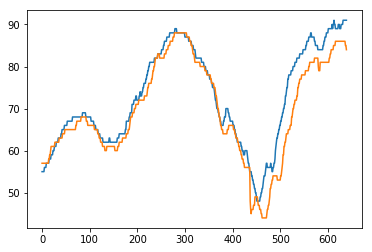

In [9]:
path_d = "../data/data_geo3k/dem.txt"
path_r = "../data/data_geo3k/real.txt"
skylines_d = read_data(path_d)
skylines_r = read_data(path_r)
print(len(skylines_d))
plt.plot(skylines_d[0])
plt.plot(skylines_r[0])

In [14]:
print(len(skylines_d[1752]))
print(len(skylines_r[1752]))

640
439


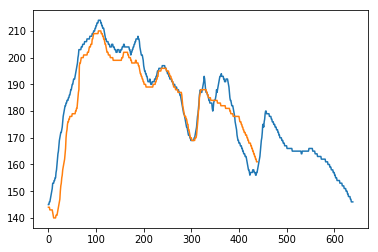

In [12]:
plt.plot(skylines_d[1752])
plt.plot(skylines_r[1752])

# datasets prepare

   构建训练样本和测试样本

In [16]:
def datasets_prepare(lines_d, lines_r, train=True):
    if train:
        if "train" in os.listdir("../data/"):
            shutil.rmtree('../data/train')  
        os.mkdir("../data/train")
        
        if "train_val" in os.listdir("../data/"):
            shutil.rmtree("../data/train_val")
        os.mkdir("../data/train_val")
        
       
        # train P samples
        for i in trange(cfg_num):
            index = random.randint(0, len(lines_d)-1)
            for j in range(cfg_counts):
                left = random.randint(0, min(len(lines_d[index]), len(lines_r[index]))-cfg_length-1)
                right = left + cfg_length
                str_tmp = str(lines_r[index][left:right]).split('[')[1].split(']')[0].replace(' ', '') + ' ' \
                          + str(lines_d[index][left:right]).split('[')[1].split(']')[0].replace(' ', '') + ' ' \
                          + '1'
                
                #  get train-positive samples
                with open("../data/train/{}.{}.txt".format(i, j), 'w') as f_a:
                    f_a.write(str_tmp)
               # get train_val for calculate top-N
                if j == 0 and i < 1000:
                    with open("../data/train_val/{}.{}".format(i, j), 'w') as f_a:
                        f_a.write(str_tmp)
                    
        # train N samples       
        for i in trange(cfg_num, 2*cfg_num):
            index_d = random.randint(0, len(lines_d)-1)
            index_r = random.randint(0, len(lines_d)-1)
            if index_d == index_r:
                index_r += 1
            for j in range(cfg_counts):
                left = random.randint(0, min(len(lines_d[index_d]), len(lines_r[index_r]))-cfg_length-1)
                right = left + cfg_length
                str_tmp = str(lines_r[index_r][left:right]).split('[')[1].split(']')[0].replace(' ', '') + ' ' \
                          + str(lines_d[index_d][left:right]).split('[')[1].split(']')[0].replace(' ', '') + ' ' \
                          + '0'
                with open("../data/train/{}.{}.txt".format(i, j), 'w') as f_a:
                    f_a.write(str_tmp)          
                        
    else:
        if "test" in os.listdir("../data/"):
            shutil.rmtree('../data/test')  
        os.mkdir("../data/test")
        
        if "val" in os.listdir("../data/"):
            shutil.rmtree('../data/val')
        os.mkdir("../data/val")
        
        # test  sample 752
        for i in trange(752):
            index = i
            for j in range(1):
                left = random.randint(0, min(len(lines_d[index]), len(lines_r[index]))-cfg_length-1)
                right = left + cfg_length
                str_tmp = str(lines_r[index][left:right]).split('[')[1].split(']')[0].replace(' ', '') + ' ' \
                          + str(lines_d[index][left:right]).split('[')[1].split(']')[0].replace(' ', '') + ' ' \
                          + '1'
                
                # get test samples for calculate top-N
                with open("../data/test/{}.{}.txt".format(i, j), 'w') as f_a:
                    f_a.write(str_tmp)
                # get val samples for train-val
                with open("../data/val/{}.{}.txt".format(i, j), 'w') as f_a:
                    f_a.write(str_tmp)
                
        # test N samples       
        for i in trange(752, 752*2):
            index_d = random.randint(0, len(lines_d)-1)
            index_r = random.randint(0, len(lines_d)-1)
            if index_d == index_r:
                index_r += 1
            for j in range(1):
                left = random.randint(0, min(len(lines_d[index_d]), len(lines_r[index_r]))-cfg_length-1)
                right = left + cfg_length
                str_tmp = str(lines_r[index_r][left:right]).split('[')[1].split(']')[0].replace(' ', '') + ' ' \
                          + str(lines_d[index_d][left:right]).split('[')[1].split(']')[0].replace(' ', '') + ' ' \
                          + '0'
               
            # get val_negtive samples
                with open("../data/val/{}.{}.txt".format(i, j), 'w') as f_a:
                    f_a.write(str_tmp)
                
# build                
datasets_prepare(skylines_d[:1000], skylines_r[:1000], train=True)
datasets_prepare(skylines_d[1000:1752], skylines_r[1000:1752], train=False)

100%|██████████| 752/752 [00:00<00:00, 7567.80it/s]


(0, 480)

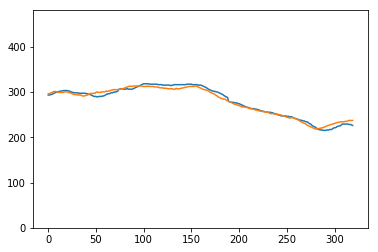

In [24]:
# visual data
id0 = random.randint(0, 9999)
id1 = random.randint(0, 4)
skyline_ = read_data_row("../data/train/{}.{}.txt".format(id0, id1), 1)
skyline = skyline_.strip().split(" ")
line0 = np.array(list(map(int, skyline[0].split(','))))
line1 = np.array(list(map(int, skyline[1].split(','))))
# line2 = Rotate()(line0)
plt.plot(line0)
plt.plot(line1)
# plt.plot(line2)
plt.ylim(0,480)

In [27]:
class Rotate(object):
    def __call__(self, line):
        angle = random.randint(-6,6)
        print(angle)
        pointx = len(line)//2
        pointy = line[pointx]
        angle = float(angle) * 3.1415  / float(180)
        x = np.arange(len(line))
        y = (x-pointx) * math.sin(angle) + (line - pointy) * math.cos(angle) + pointy
        
        return y
    
class Move(object):
    def __call__(self, line):
        delta = random.randint(-100,100)
        print(delta)
        return line + delta

-82
2


(0, 480)

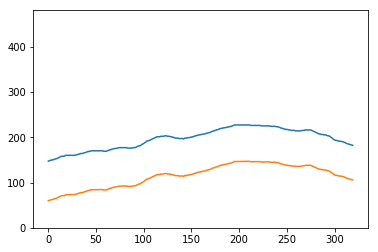

In [59]:
# show rotate and 
id0 = random.randint(0, 9999)
id1 = random.randint(0, 4)
skyline_ = read_data_row("../data/train/{}.{}.txt".format(id0, id1), 1)
skyline = skyline_.strip().split(" ")
line0 = np.array(list(map(int, skyline[0].split(','))))
line2 = Move()(line0)
line2 = Rotate()(line2)

plt.plot(line0)
plt.plot(line2)
plt.ylim(0,480)

# 差值统计

In [40]:
root_path = "../data/train/"
filenames = os.listdir(root_path)
point_x = []
point_y = []
for filename in tqdm(filenames):
    skyline_ = read_data_row(os.path.join(root_path, filename), 1)
    skyline = skyline_.strip().split(" ")
    err = sum(abs(np.array(list(map(int, skyline[0].split(',')))) - 
            np.array(list(map(int, skyline[1].split(','))))))
    point_x.append(err)
    point_y.append(np.array(list(map(int, skyline[2])))[0]*10+5)



100%|██████████| 100000/100000 [02:05<00:00, 795.26it/s]


<BarContainer object of 100000 artists>

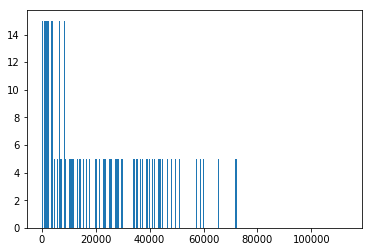

In [41]:
plt.bar(point_x[:100000], point_y[:100000])

(0, 100000)

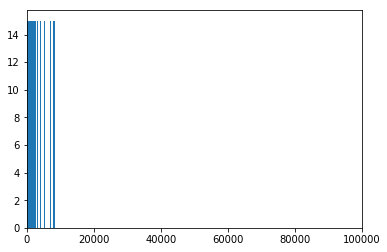

In [42]:
ptx = np.array(point_x[:100000])
pty = np.array(point_y[:100000])

plt.bar(ptx[pty==15], pty[pty==15])
plt.xlim(0, 100000)

(0, 15)

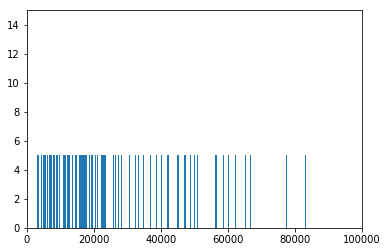

In [43]:
ptx = np.array(point_x[:100000])
pty = np.array(point_y[:100000])

plt.bar(ptx[pty==5], pty[pty==5])
plt.xlim(0, 100000)
plt.ylim(0, 15)

In [45]:
print(len([point_x[i] for i in range(len(point_x)) if  point_x[i] < 1000 and point_y[i]==5]))

0
